In [19]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 11

# Paths
RESULTS_DIR = Path('../results')
DATASETS_DIR = Path('../datasets')

def load_json(path):
    with open(path) as f:
        return json.load(f)

print("Setup complete.")

Setup complete.


---
# Task 1: Intent Classification

**Complexity:** Simple (pattern matching)

**Task:** Classify customer support queries into 27 intent categories

**Optimizer:** BootstrapFewShot

## 1.1 Dataset: Bitext Customer Support (27K examples)

In [ ]:
bitext_df = pd.read_csv(DATASETS_DIR / 'Bitext_Sample_Customer_Support_Training_Dataset_27K_responses-v11.csv')

print("="*60)
print("BITEXT DATASET OVERVIEW")
print("="*60)
print(f"Total examples: {len(bitext_df):,}")
print(f"Intent categories: {bitext_df['intent'].nunique()}")
print(f"Columns: {list(bitext_df.columns)}")
print()
print("Intent distribution (top 10):")
print(bitext_df['intent'].value_counts().head(10))

BITEXT DATASET OVERVIEW
Total examples: 26,872
Intent categories: 27
Columns: ['flags', 'instruction', 'category', 'intent', 'response']

Intent distribution (top 10):
intent
edit_account                1000
switch_account              1000
check_invoice               1000
complaint                   1000
contact_customer_service    1000
delivery_period              999
registration_problems        999
check_payment_methods        999
contact_human_agent          999
payment_issue                999
Name: count, dtype: int64


In [21]:
print("="*60)
print("EXAMPLE: Intent Classification Data")
print("="*60)
print()
print("Task: Given a query, predict the intent\n")

sample_intents = ['cancel_order', 'track_order', 'get_refund', 'complaint', 'create_account']
for intent in sample_intents:
    example = bitext_df[bitext_df['intent'] == intent].iloc[0]
    print(f"Query:  \"{example['instruction']}\"")
    print(f"Intent: {example['intent']}")
    print("-"*60)

EXAMPLE: Intent Classification Data

Task: Given a query, predict the intent

Query:  "question about cancelling order {{Order Number}}"
Intent: cancel_order
------------------------------------------------------------
Query:  "needx help to check the ETA of purchase {{Order Number}}"
Intent: track_order
------------------------------------------------------------
Query:  "how do I get a compensation of my money?"
Intent: get_refund
------------------------------------------------------------
Query:  "help me to file a claim"
Intent: complaint
------------------------------------------------------------
Query:  "new {{Account Type}} acount for wife"
Intent: create_account
------------------------------------------------------------


## 1.2 Results: Intent Classification

We tested multiple BootstrapFewShot configurations to see if different settings improve results:
- **demos**: Number of few-shot examples (4 vs 8)
- **rounds**: Optimization iterations (1 vs 2)  
- **train size**: Training examples (200 vs 500)

In [23]:
intent_experiments = {
    'd4_r1_tr200': load_json(RESULTS_DIR / 'intent_classification' / 'optimization_d4_r1_tr200.json'),
    'd4_r1_tr500': load_json(RESULTS_DIR / 'intent_classification' / 'optimization_d4_r1_tr500.json'),
    'd8_r2_tr200': load_json(RESULTS_DIR / 'intent_classification' / 'optimization_d8_r2_tr200.json'),
}

comparison_data = []
for name, exp in intent_experiments.items():
    comparison_data.append({
        'Experiment': name,
        'Demos': exp['optimizer_settings']['max_bootstrapped_demos'],
        'Rounds': exp['optimizer_settings']['max_rounds'],
        'Train': exp['dataset_sizes']['train'],
        'Test': exp['dataset_sizes']['test'],
        'Baseline': exp['baseline']['accuracy'],
        'Optimized': exp['optimized']['accuracy'],
        'Improvement': exp['improvement']['absolute'],
    })

df_intent = pd.DataFrame(comparison_data)

print("="*70)
print("INTENT CLASSIFICATION: COMPARING BOOTSTRAPFEWSHOT CONFIGURATIONS")
print("="*70)
print()
print(df_intent.to_string(index=False))
print()
print("="*70)
print("KEY FINDING: No configuration improves classification accuracy!")
print("="*70)

intent_results = intent_experiments['d4_r1_tr200']

INTENT CLASSIFICATION: COMPARING BOOTSTRAPFEWSHOT CONFIGURATIONS

 Experiment  Demos  Rounds  Train  Test  Baseline  Optimized  Improvement
d4_r1_tr200      4       1    200    50      92.0       90.0         -2.0
d4_r1_tr500      4       1    500   100      85.0       85.0          0.0
d8_r2_tr200      8       2    200    50      92.0       92.0          0.0

KEY FINDING: No configuration improves classification accuracy!


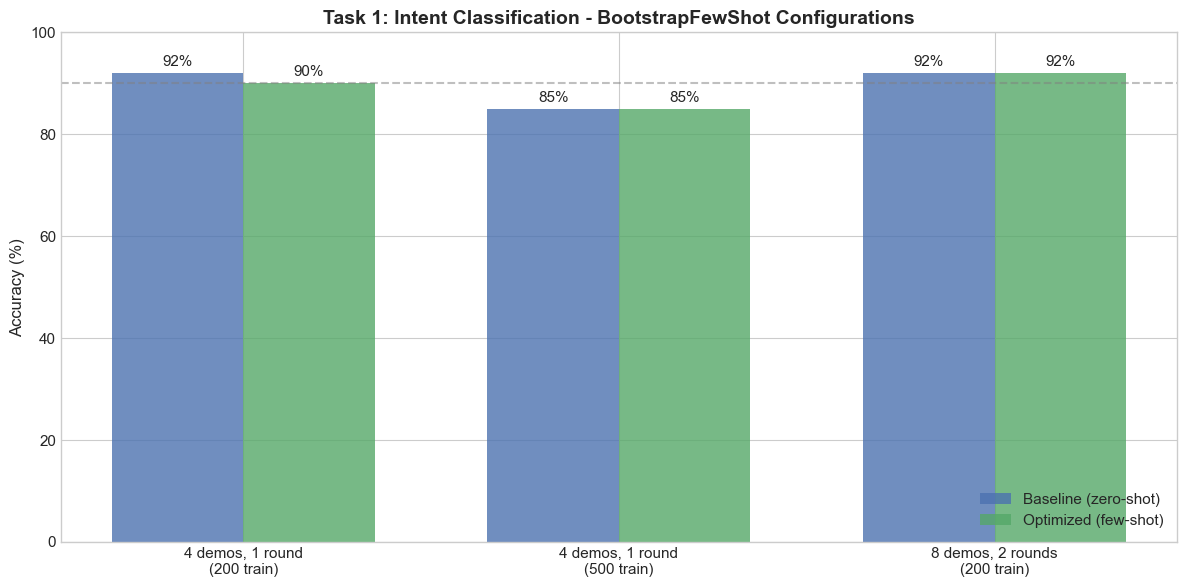


>> INSIGHT: LLMs already achieve 85-92% accuracy on simple classification.
>> NO configuration improves results - optimization is unnecessary for simple tasks.
>> More demos, more rounds, more data - none of it helps when baseline is already good.


In [24]:
fig, ax = plt.subplots(figsize=(12, 6))

experiments = list(intent_experiments.keys())
x = np.arange(len(experiments))
width = 0.35

baseline_accs = [intent_experiments[e]['baseline']['accuracy'] for e in experiments]
optimized_accs = [intent_experiments[e]['optimized']['accuracy'] for e in experiments]

bars1 = ax.bar(x - width/2, baseline_accs, width, label='Baseline (zero-shot)', color='#4C72B0', alpha=0.8)
bars2 = ax.bar(x + width/2, optimized_accs, width, label='Optimized (few-shot)', color='#55A868', alpha=0.8)

for bar in bars1:
    height = bar.get_height()
    ax.annotate(f'{height:.0f}%', xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=11)

for bar in bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.0f}%', xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=11)

labels = ['4 demos, 1 round\n(200 train)', '4 demos, 1 round\n(500 train)', '8 demos, 2 rounds\n(200 train)']
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel('Accuracy (%)', fontsize=12)
ax.set_title('Task 1: Intent Classification - BootstrapFewShot Configurations', fontsize=14, fontweight='bold')
ax.set_ylim(0, 100)
ax.legend(loc='lower right')
ax.axhline(y=90, color='gray', linestyle='--', alpha=0.5, label='90% threshold')

plt.tight_layout()
plt.show()

print("\n>> INSIGHT: LLMs already achieve 85-92% accuracy on simple classification.")
print(">> NO configuration improves results - optimization is unnecessary for simple tasks.")
print(">> More demos, more rounds, more data - none of it helps when baseline is already good.")

---
# Task 2: Response Generation

**Complexity:** Moderate (requires understanding + generation)

**Task:** Generate helpful customer support responses

**Optimizer:** MIPROv2 (Light vs Medium modes)

**Evaluation:** LLM-as-Judge (scores responses 0.0-1.0 based on helpfulness, empathy, professionalism)

## 2.1 Example Data: Response Generation

In [25]:
print("="*60)
print("EXAMPLE: Response Generation Data")
print("="*60)
print()
print("Task: Given query + intent, generate a helpful response\n")

sample_intents = ['cancel_order', 'track_order', 'get_refund']
for intent in sample_intents:
    example = bitext_df[bitext_df['intent'] == intent].iloc[0]
    print(f"INPUT")
    print(f"  Query:  \"{example['instruction']}\"")
    print(f"  Intent: {example['intent']}")
    print(f"\nEXPECTED OUTPUT")
    print(f"  Response: \"{example['response'][:150]}...\"")
    print("="*60)

EXAMPLE: Response Generation Data

Task: Given query + intent, generate a helpful response

INPUT
  Query:  "question about cancelling order {{Order Number}}"
  Intent: cancel_order

EXPECTED OUTPUT
  Response: "I've understood you have a question regarding canceling order {{Order Number}}, and I'm here to provide you with the information you need. Please go a..."
INPUT
  Query:  "needx help to check the ETA of purchase {{Order Number}}"
  Intent: track_order

EXPECTED OUTPUT
  Response: "Your message means a lot! I'm aligned with the idea that you need assistance with checking the Estimated Time of Arrival (ETA) for your purchase with ..."
INPUT
  Query:  "how do I get a compensation of my money?"
  Intent: get_refund

EXPECTED OUTPUT
  Response: "I can see that you're seeking guidance on how to obtain a compensation for your money. Rest assured, I'm here to assist you with the necessary steps. ..."


## 2.2 Results: Response Generation

We tested two MIPROv2 optimization intensities:
- **Light**: ~10-20 trials, faster, cheaper
- **Medium**: ~30-50 trials, more thorough search

In [26]:
response_experiments = {
    'light_tr100': load_json(RESULTS_DIR / 'response_generation' / 'optimization_light_tr100.json'),
    'medium_tr100': load_json(RESULTS_DIR / 'response_generation' / 'optimization_medium_tr100.json'),
}

comparison_data = []
for name, exp in response_experiments.items():
    comparison_data.append({
        'Experiment': name,
        'Mode': exp['optimizer_settings']['auto'],
        'Train': exp['dataset_sizes']['train'],
        'Test': exp['dataset_sizes']['test'],
        'Baseline': f"{exp['baseline']['average_quality']:.3f}",
        'Optimized': f"{exp['optimized']['average_quality']:.3f}",
        'Improvement': f"{exp['improvement']['absolute']:.3f} ({exp['improvement']['percentage']:+.1f}%)",
    })

df_response = pd.DataFrame(comparison_data)

print("="*70)
print("RESPONSE GENERATION: COMPARING MIPROv2 CONFIGURATIONS")
print("="*70)
print()
print(df_response.to_string(index=False))
print()
print("="*70)
print("KEY FINDING: Medium mode provides better improvement (+9.5% vs +3.1%)")
print("="*70)

# Store best result for summary (medium mode)
response_results = response_experiments['medium_tr100']

RESPONSE GENERATION: COMPARING MIPROv2 CONFIGURATIONS

  Experiment   Mode  Train  Test Baseline Optimized   Improvement
 light_tr100  light    100    50    0.713     0.735 0.022 (+3.1%)
medium_tr100 medium    100    50    0.713     0.781 0.068 (+9.5%)

KEY FINDING: Medium mode provides better improvement (+9.5% vs +3.1%)


In [27]:
# Show discovered instructions for each configuration
print("="*70)
print("DISCOVERED INSTRUCTIONS (MIPROv2)")
print("="*70)
print()
print("BASELINE (original signature docstring):")
print(f"  \"{response_experiments['light_tr100']['baseline']['instructions']}\"")
print()
print("-"*70)
print()
print("LIGHT MODE discovered:")
print(f"  \"{response_experiments['light_tr100']['optimized']['instructions'][:150]}...\"")
print()
print("MEDIUM MODE discovered:")
print(f"  \"{response_experiments['medium_tr100']['optimized']['instructions']}\"")
print()
print("="*70)
print("Both modes discovered similar patterns: professional, empathetic, clear next steps")
print("="*70)

DISCOVERED INSTRUCTIONS (MIPROv2)

BASELINE (original signature docstring):
  "Generate a helpful customer support response."

----------------------------------------------------------------------

LIGHT MODE discovered:
  "Given a customer support query and the detected customer intent, use the `Predict(query, intent)` module to predict the reasoning behind the query and..."

MEDIUM MODE discovered:
  "Given a customer support query and a detected intent, provide a step-by-step reasoning process to understand the context and then formulate a professional and empathetic response with clear next steps for the customer."

Both modes discovered similar patterns: professional, empathetic, clear next steps


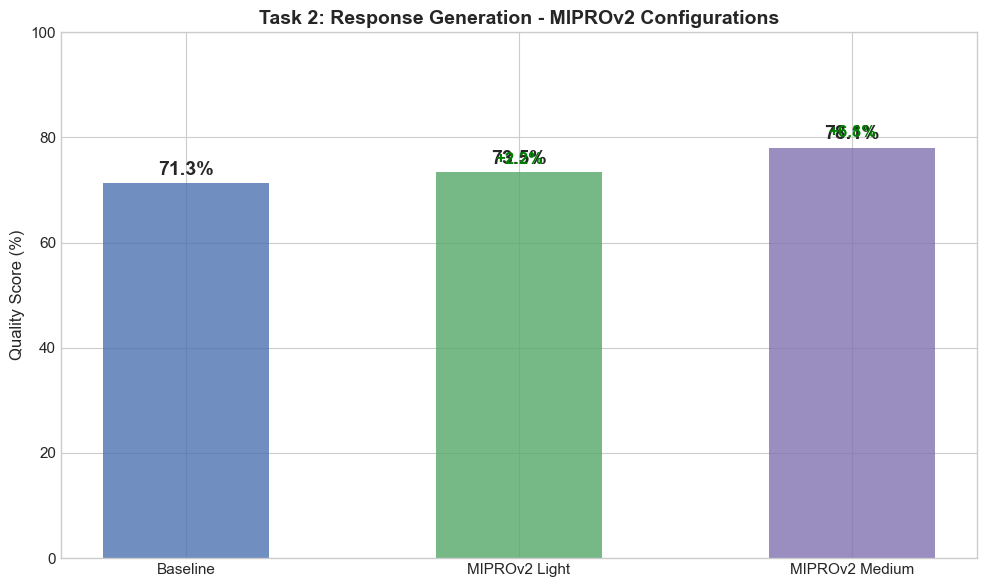


>> INSIGHT: More optimization trials = better results
>> Light mode: +3.1% improvement
>> Medium mode: +9.5% improvement (3x better than light!)
>> MIPROv2 discovers specific instructions: 'professional, empathetic, clear next steps'


In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

categories = ['Baseline', 'MIPROv2 Light', 'MIPROv2 Medium']
qualities = [
    response_experiments['light_tr100']['baseline']['average_quality'] * 100,
    response_experiments['light_tr100']['optimized']['average_quality'] * 100,
    response_experiments['medium_tr100']['optimized']['average_quality'] * 100,
]
colors = ['#4C72B0', '#55A868', '#8172B2']

bars = ax.bar(categories, qualities, color=colors, alpha=0.8, width=0.5)

for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.1f}%',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points",
                ha='center', va='bottom', fontsize=14, fontweight='bold')

light_imp = response_experiments['light_tr100']['improvement']['absolute'] * 100
medium_imp = response_experiments['medium_tr100']['improvement']['absolute'] * 100
ax.annotate(f'+{light_imp:.1f}%', xy=(1, 75), fontsize=12, color='green', fontweight='bold', ha='center')
ax.annotate(f'+{medium_imp:.1f}%', xy=(2, 80), fontsize=12, color='green', fontweight='bold', ha='center')

ax.set_ylabel('Quality Score (%)', fontsize=12)
ax.set_title('Task 2: Response Generation - MIPROv2 Configurations', fontsize=14, fontweight='bold')
ax.set_ylim(0, 100)

plt.tight_layout()
plt.show()

print("\n>> INSIGHT: More optimization trials = better results")
print(">> Light mode: +3.1% improvement")
print(">> Medium mode: +9.5% improvement (3x better than light!)")
print(">> MIPROv2 discovers specific instructions: 'professional, empathetic, clear next steps'")

---
# Task 3: Math Reasoning

**Complexity:** Complex (multi-step reasoning)

**Task:** Solve grade-school math word problems (GSM8K dataset)

**Optimizer:** MIPROv2 (Light vs Medium modes)

**Why Complex?** Requires chain-of-thought reasoning - model must "show work" to get right answer

## 3.1 Example Data: Math Problems

In [ ]:
gsm8k_examples = []
with open(DATASETS_DIR / 'test.jsonl') as f:
    for i, line in enumerate(f):
        if i >= 5:  
            break
        gsm8k_examples.append(json.loads(line))

print("="*60)
print("EXAMPLE: Math Reasoning Data (GSM8K)")
print("="*60)
print()
print("Task: Solve math word problems with step-by-step reasoning\n")

for i, ex in enumerate(gsm8k_examples[:3], 1):
    print(f"PROBLEM {i}:")
    print(f"  {ex['question']}")
    print()

    answer = ex['answer'].split('####')[-1].strip()
    print(f"  ANSWER: {answer}")
    print("="*60)

EXAMPLE: Math Reasoning Data (GSM8K)

Task: Solve math word problems with step-by-step reasoning

PROBLEM 1:
  Janet’s ducks lay 16 eggs per day. She eats three for breakfast every morning and bakes muffins for her friends every day with four. She sells the remainder at the farmers' market daily for $2 per fresh duck egg. How much in dollars does she make every day at the farmers' market?

  ANSWER: 18
PROBLEM 2:
  A robe takes 2 bolts of blue fiber and half that much white fiber.  How many bolts in total does it take?

  ANSWER: 3
PROBLEM 3:
  Josh decides to try flipping a house.  He buys a house for $80,000 and then puts in $50,000 in repairs.  This increased the value of the house by 150%.  How much profit did he make?

  ANSWER: 70000


## 3.2 Results: Math Reasoning

We tested two MIPROv2 optimization intensities:
- **Light**: ~10-20 trials, faster, cheaper
- **Medium**: ~30-50 trials, more thorough search

In [30]:
math_experiments = {
    'light_tr300': load_json(RESULTS_DIR / 'math_solver' / 'optimization_light_tr300.json'),
    'medium_tr300': load_json(RESULTS_DIR / 'math_solver' / 'optimization_medium_tr300.json'),
}

comparison_data = []
for name, exp in math_experiments.items():
    comparison_data.append({
        'Experiment': name,
        'Mode': exp['optimizer_settings']['auto'],
        'Train': exp['dataset_sizes']['train'],
        'Test': exp['dataset_sizes']['test'],
        'Baseline': f"{exp['baseline']['accuracy']:.1f}%",
        'Optimized': f"{exp['optimized']['accuracy']:.1f}%",
        'Improvement': f"+{exp['improvement']['absolute']:.1f}%",
    })

df_math = pd.DataFrame(comparison_data)

print("="*70)
print("MATH REASONING: COMPARING MIPROv2 CONFIGURATIONS")
print("="*70)
print()
print(df_math.to_string(index=False))
print()
print("="*70)
print("KEY FINDING: Medium mode provides +20% vs Light's +13% improvement!")
print("="*70)

math_results = math_experiments['medium_tr300']

MATH REASONING: COMPARING MIPROv2 CONFIGURATIONS

  Experiment   Mode  Train  Test Baseline Optimized Improvement
 light_tr300  light    300   100    67.0%     80.0%      +13.0%
medium_tr300 medium    300   100    67.0%     87.0%      +20.0%

KEY FINDING: Medium mode provides +20% vs Light's +13% improvement!


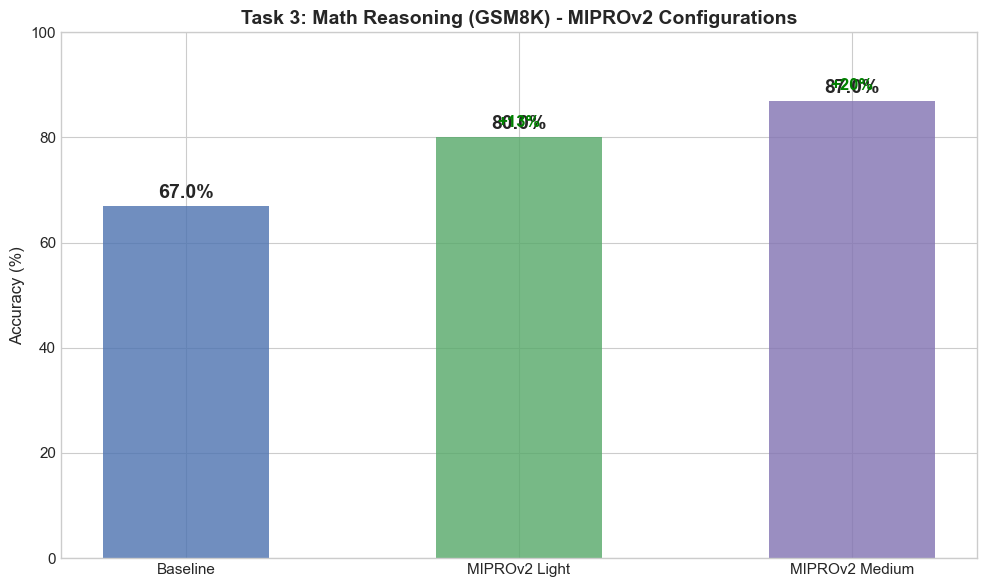


>> INSIGHT: HUGE improvement from optimization!
>> Light mode: +13% improvement (67% → 80%)
>> Medium mode: +20% improvement (67% → 87%)
>> Complex reasoning tasks benefit significantly from more optimization trials!


In [31]:
fig, ax = plt.subplots(figsize=(10, 6))

categories = ['Baseline', 'MIPROv2 Light', 'MIPROv2 Medium']
accuracies = [
    math_experiments['light_tr300']['baseline']['accuracy'],
    math_experiments['light_tr300']['optimized']['accuracy'],
    math_experiments['medium_tr300']['optimized']['accuracy'],
]
colors = ['#4C72B0', '#55A868', '#8172B2']

bars = ax.bar(categories, accuracies, color=colors, alpha=0.8, width=0.5)

for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.1f}%',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points",
                ha='center', va='bottom', fontsize=14, fontweight='bold')

light_imp = math_experiments['light_tr300']['improvement']['absolute']
medium_imp = math_experiments['medium_tr300']['improvement']['absolute']
ax.annotate(f'+{light_imp:.0f}%', xy=(1, 82), fontsize=12, color='green', fontweight='bold', ha='center')
ax.annotate(f'+{medium_imp:.0f}%', xy=(2, 89), fontsize=12, color='green', fontweight='bold', ha='center')

ax.set_ylabel('Accuracy (%)', fontsize=12)
ax.set_title('Task 3: Math Reasoning (GSM8K) - MIPROv2 Configurations', fontsize=14, fontweight='bold')
ax.set_ylim(0, 100)

plt.tight_layout()
plt.show()

print("\n>> INSIGHT: HUGE improvement from optimization!")
print(">> Light mode: +13% improvement (67% → 80%)")
print(">> Medium mode: +20% improvement (67% → 87%)")
print(">> Complex reasoning tasks benefit significantly from more optimization trials!")

In [ ]:
model_light = load_json(RESULTS_DIR / 'math_solver' / 'optimized_model_light_tr300.json')
model_medium = load_json(RESULTS_DIR / 'math_solver' / 'optimized_model_medium_tr300.json')

print("="*70)
print("BASELINE vs OPTIMIZED INSTRUCTIONS")
print("="*70)
print()
print("BASELINE (zero-shot):")
print("  \"Solve math word problems using step-by-step reasoning.\"")
print("  → No demos provided")
print()
print("OPTIMIZED (Light Mode):")
print(f"  \"{model_light['predict']['signature']['instructions']}\"")
print(f"  → {len(model_light['predict']['demos'])} carefully selected demos")
print()
print("OPTIMIZED (Medium Mode):")
print(f"  \"{model_medium['predict']['signature']['instructions']}\"")
print(f"  → {len(model_medium['predict']['demos'])} carefully selected demos")
print()
print("="*70)
print("DEMO SELECTION: What patterns did MIPROv2 discover?")
print("="*70)
print()

for mode_name, model in [("Light", model_light), ("Medium", model_medium)]:
    demos = model['predict']['demos']
    print(f"{mode_name} Mode Demos ({len(demos)} total):")
    for i, demo in enumerate(demos, 1):
        q = demo['question'].lower()
        problem_type = []
        if 'percent' in q or '%' in q or '20%' in q:
            problem_type.append("percentage")
        if 'each' in q or 'per' in q:
            problem_type.append("rate/unit")
        if 'total' in q or 'altogether' in q:
            problem_type.append("aggregation")
        if '/' in demo['reasoning'] or 'divide' in demo['reasoning'].lower():
            problem_type.append("division")
        if '*' in demo['reasoning'] or 'times' in demo['reasoning'].lower():
            problem_type.append("multiplication")
        
        type_str = ", ".join(problem_type) if problem_type else "multi-step"
        print(f"  {i}. [{type_str}] {demo['question'][:60]}...")
    print()

print("="*70)
print("KEY INSIGHT: MIPROv2 selects diverse problem types as demos")
print("  → Covers percentages, rates, aggregation, multi-step reasoning")
print("  → Each demo shows clear step-by-step calculation pattern")
print("="*70)

BASELINE vs OPTIMIZED INSTRUCTIONS

BASELINE (zero-shot):
  "Solve math word problems using step-by-step reasoning."
  → No demos provided

OPTIMIZED (Light Mode):
  "Given a math word problem question, predict the step-by-step reasoning needed to solve the problem and provide the final numerical answer."
  → 4 carefully selected demos

OPTIMIZED (Medium Mode):
  "Given a math word problem, provide step-by-step reasoning and calculate the final numerical answer to solve the problem."
  → 4 carefully selected demos

DEMO SELECTION: What patterns did MIPROv2 discover?

Light Mode Demos (4 total):
  1. [rate/unit, division, multiplication] Jack has a stack of books that is 12 inches thick. He knows ...
  2. [percentage, rate/unit, division, multiplication] The school decided to add 20% to the gym budget. In a normal...
  3. [rate/unit, division, multiplication] Each dandelion produces 300 seeds. 1/3rd of the seeds land i...
  4. [aggregation, multiplication] Grant has four times as many v

---
# Summary: All Tasks Compared

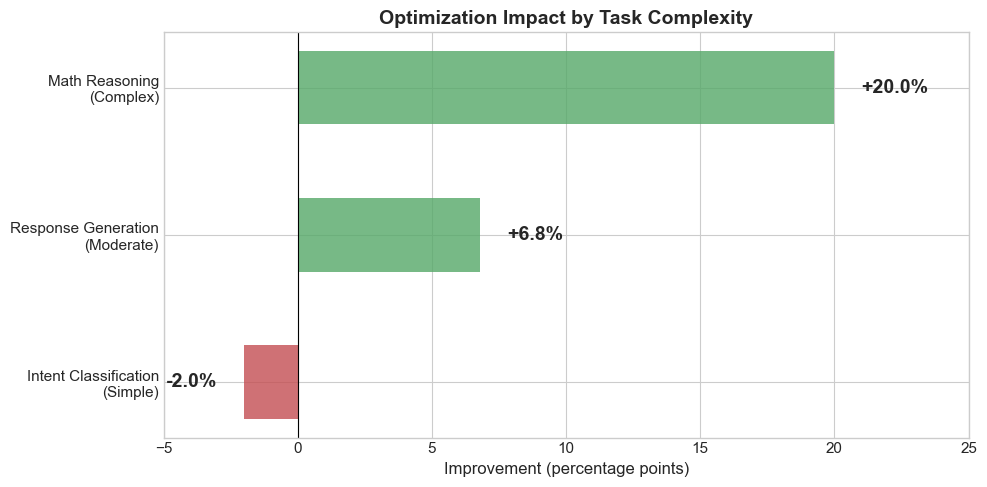

In [17]:
best_intent = intent_experiments['d4_r1_tr200']  # Highest baseline
best_response = response_experiments['medium_tr100']  # Best improvement
best_math = math_experiments['medium_tr300']  # Best improvement

# Final comparison chart - Improvement by task complexity
fig, ax = plt.subplots(figsize=(10, 5))

tasks = ['Intent Classification\n(Simple)', 'Response Generation\n(Moderate)', 'Math Reasoning\n(Complex)']
improvements = [
    best_intent['improvement']['absolute'],  # -2% (no improvement)
    best_response['improvement']['absolute'] * 100,  # +6.8% (medium mode)
    best_math['improvement']['absolute']  # +20%
]

colors = ['#C44E52' if imp < 0 else '#55A868' for imp in improvements]

bars = ax.barh(tasks, improvements, color=colors, alpha=0.8, height=0.5)

for bar, imp in zip(bars, improvements):
    width = bar.get_width()
    label_x = width + 1 if width >= 0 else width - 1
    ha = 'left' if width >= 0 else 'right'
    ax.annotate(f'{imp:+.1f}%',
                xy=(label_x, bar.get_y() + bar.get_height()/2),
                ha=ha, va='center', fontsize=14, fontweight='bold')

ax.axvline(x=0, color='black', linewidth=0.8)
ax.set_xlabel('Improvement (percentage points)', fontsize=12)
ax.set_title('Optimization Impact by Task Complexity', fontsize=14, fontweight='bold')
ax.set_xlim(-5, 25)

plt.tight_layout()
plt.show()